In [1]:
import os
os.chdir(os.path.dirname(os.path.dirname(os.getcwd())))

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scienceplots

In [3]:
# read together forecast
tog_forecast = pd.read_csv('data/together_forecast/phase_1_forecast_sampled_1h.csv')
tog_forecast = tog_forecast.set_index('time_step')
tog_forecast 

,scenario,building,+0h,+1h,+2h,+3h,+4h,+5h,+6h,+7h,...,+14h,+15h,+16h,+17h,+18h,+19h,+20h,+21h,+22h,+23h
time_step,,,,,,,,,,,,,,,,,,,,,
0,0,0,1.315463,0.997405,0.882386,0.827967,0.815308,0.853358,0.710826,0.255466,...,-0.335835,0.450289,0.835517,1.262387,1.473747,1.314026,1.357523,1.363334,1.404195,1.280302
0,0,1,1.250480,0.990671,0.878696,0.825506,0.813198,0.851392,0.709265,0.254513,...,-0.340026,0.449820,0.834876,1.261625,1.473639,1.312518,1.356081,1.361599,1.401595,1.275230
0,0,2,0.334184,0.505538,0.559403,0.592007,0.637254,0.685898,0.604959,0.175989,...,-0.341320,0.449186,0.798859,1.208564,1.391791,1.241544,1.262507,1.228239,1.160263,0.833793
0,0,3,1.501574,1.066869,0.904937,0.844253,0.837024,0.860239,0.655470,0.086987,...,-0.742460,0.219726,0.673009,1.202868,1.476299,1.326355,1.377343,1.370731,1.424389,1.315757
0,0,4,0.761706,0.742030,0.697915,0.701616,0.719273,0.756398,0.633275,0.210226,...,-0.350937,0.439368,0.792496,1.234261,1.410800,1.273827,1.292093,1.267927,1.206125,1.044829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8759,0,0,1.669145,0.967867,0.877480,0.929736,0.935463,1.051124,1.248356,1.070367,...,-1.032682,-0.577529,0.007843,1.208888,2.519401,2.931290,2.964769,2.673315,2.317424,1.999848
8759,0,1,2.245950,1.931647,1.289904,0.990013,0.751804,0.593789,0.528411,0.752680,...,0.035232,0.240522,0.254429,0.254242,0.614973,1.398581,1.140973,1.190661,1.388406,1.838529
8759,0,2,0.975433,0.663972,0.611254,0.637533,0.561356,0.561906,0.657419,0.700056,...,-0.811553,-0.447578,-0.221324,0.060082,0.393557,1.379672,1.223565,1.117971,1.134075,1.191572


In [4]:
def find_overlap(horizon, step):
    overlap = [i for i in range(step,horizon)]
    return overlap

def sMAPC(y_forecast, y_forecast_previous):
    h = len(y_forecast)
    if h != len(y_forecast_previous):
        raise ValueError("Input lists must have the same length")
    s_mapc = 0
    for i in range(1, h):
        numerator = abs(y_forecast[i] - y_forecast_previous[i])
        denominator = abs(y_forecast[i]) + abs(y_forecast_previous[i])
        s_mapc += numerator / denominator
    s_mapc *= (200 / (h - 1))
    return s_mapc

def MAC(y_forecast, y_forecast_previous):
    h = len(y_forecast)
    if h != len(y_forecast_previous):
        raise ValueError("Input lists must have the same length")
    mac = 0
    for i in range(h):
        numerator = abs(y_forecast[i] - y_forecast_previous[i])
        mac += numerator
    mac /= (h)
    return mac


In [5]:
def generate_lists(step, horizon):
    previous_list = np.arange(step, horizon)
    current_list = np.arange(horizon - step)
    return previous_list, current_list

def generate_lists_same_line(step, horizon):
    previous_list = np.arange(step+1, horizon)
    current_list = np.arange(horizon - step - 1)
    return previous_list, current_list

In [6]:
phase_num = 1
#sMAPC_steps = {}
MAC_steps = {}
#sMAPC_steps_dict = {}
MAC_steps_dict = {}
for step_forecast in range(1, 24):
    #sMAPC_steps[step_forecast] = {}
    MAC_steps[step_forecast] = {}
    tog_forecast = pd.read_csv(f'debug_logs/scen_gurobi_phase_{phase_num}_step_leap_1_forecast_step_{step_forecast}.csv', index_col='time_step')
    for b_num in range(tog_forecast['building'].nunique()):
        tog_forecast_temp = tog_forecast[tog_forecast['building'] == b_num]
        tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
        # impute the row above for missing indexes
        tog_forecast_array = tog_forecast_temp.values
        #sMAPC_v = np.zeros(len(tog_forecast_temp)-1)
        MAC_v = np.zeros(len(tog_forecast_temp)-1)
        prev_indices, current_indices = generate_lists(1,24)
        for i in range(len(tog_forecast_temp)-1):
            #step_shift = i % step_forecast
            #print(step_shift)
            #print(prev_indices, current_indices)
            tog_forecast_previous = tog_forecast_array[i, prev_indices]
            tog_forecast_current = tog_forecast_array[i+1, current_indices]
            #sMAPC_v[i] = sMAPC(tog_forecast_current, tog_forecast_previous)
            MAC_v[i] = MAC(tog_forecast_current, tog_forecast_previous)
        #print(f'sMAPC{sMAPC_v.mean()}')
        print(f'MAC{MAC_v.mean()}')
        #sMAPC_steps[step_forecast][b_num] = sMAPC_v.mean()
        MAC_steps[step_forecast][b_num] = MAC_v.mean()
    # sMAPC_steps_dict[step] equals to average of sMAPC over all buildings
    #sMAPC_steps_dict[step_forecast] = np.mean(list(sMAPC_steps[step_forecast].values()))
    MAC_steps_dict[step_forecast] = np.mean(list(MAC_steps[step_forecast].values()))

/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

MAC0.040932536038752604
MAC0.035641149994379215
MAC0.03217275461570636


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)


MAC0.03455897757494873
MAC0.030452913541451767


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

MAC0.02610227583274541
MAC0.02217415486266495
MAC0.020354460395496186
MAC0.02128903303967562


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)


MAC0.018936497251450544


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

MAC0.019907228091931066
MAC0.017081283316713856
MAC0.015545658486118958


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)


MAC0.01632484195756714
MAC0.014851776532241345


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

MAC0.016434336873084904
MAC0.014380866877794982
MAC0.01311931328089575
MAC0.013457898676843561


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)


MAC0.01173423933928171


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

MAC0.014063250128755894
MAC0.012447829957999541
MAC0.011584384122283657
MAC0.011836873746457538


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)


MAC0.01036656717165075


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

MAC0.012941755065436858
MAC0.011392576535625469
MAC0.010642143537072034
MAC0.010657023348746679
MAC0.00961824931292189


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

MAC0.01188046105543776
MAC0.010619647222224382
MAC0.010010623342892195
MAC0.009979650330578625


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)


MAC0.008858867866875175


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

MAC0.011161979309531743
MAC0.010446765200358915
MAC0.009565258381313425
MAC0.009767835998711805


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)


MAC0.008409742071723547


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

MAC0.011160890401452267
MAC0.009597528631302673
MAC0.009105268863687701
MAC0.009323591060047367
MAC0.00831165047225129


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

MAC0.010795967759578745
MAC0.009418323901748652
MAC0.00892224208111741
MAC0.009166477125220193


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)


MAC0.007981958586053184


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

MAC0.01061534088709972
MAC0.009508558094328304
MAC0.008918168497022028
MAC0.009104491674524942


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)


MAC0.007883665084883593


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

MAC0.010724375211071705
MAC0.00960427720517997
MAC0.008691362566775678
MAC0.00920744400902821


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)


MAC0.007837137177332334


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

MAC0.010623019165989702
MAC0.009283580754429506
MAC0.008737756656688807
MAC0.009143420319751183


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)


MAC0.007916882129918631


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

MAC0.010822633877945813
MAC0.009504642727139877
MAC0.008852259281775632
MAC0.00921906468751103


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)


MAC0.007991497177932717
MAC0.010931060417817039


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

MAC0.009545647540539359
MAC0.008870605742637469
MAC0.009328581843269625
MAC0.008112925720131002


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

MAC0.01085488339606715
MAC0.009697442872276472
MAC0.009031853346310428
MAC0.009546376232637585
MAC0.008156826640502372


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

MAC0.011312650150841163
MAC0.009934360969168572
MAC0.009138237550406202
MAC0.0096867955465217


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)


MAC0.008346735373208326


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

MAC0.01161359852890107
MAC0.010060684748411618
MAC0.009253226588907943
MAC0.009903722524675444


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)


MAC0.00856182623549263
MAC0.01186688415113242


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

MAC0.010371313229760912
MAC0.009576626454162056
MAC0.010137225069463799
MAC0.008833363725070003


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

MAC0.01221895751966239
MAC0.010568462456519299
MAC0.009725406661465642
MAC0.010392060282823502


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)


MAC0.008967257247414743
MAC0.012532413025562801


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

MAC0.010899764960435326
MAC0.009917423344994144
MAC0.010667630904323596
MAC0.009211437341909724


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

MAC0.01297801948368826
MAC0.011278388820842427
MAC0.010294250534684257
MAC0.010966681514999391


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)


MAC0.009540609324046694
MAC0.013453149701777089


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_31941/4228737761.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

MAC0.01165737609741253
MAC0.010588210200898826
MAC0.01140391288414626
MAC0.00996883051388282


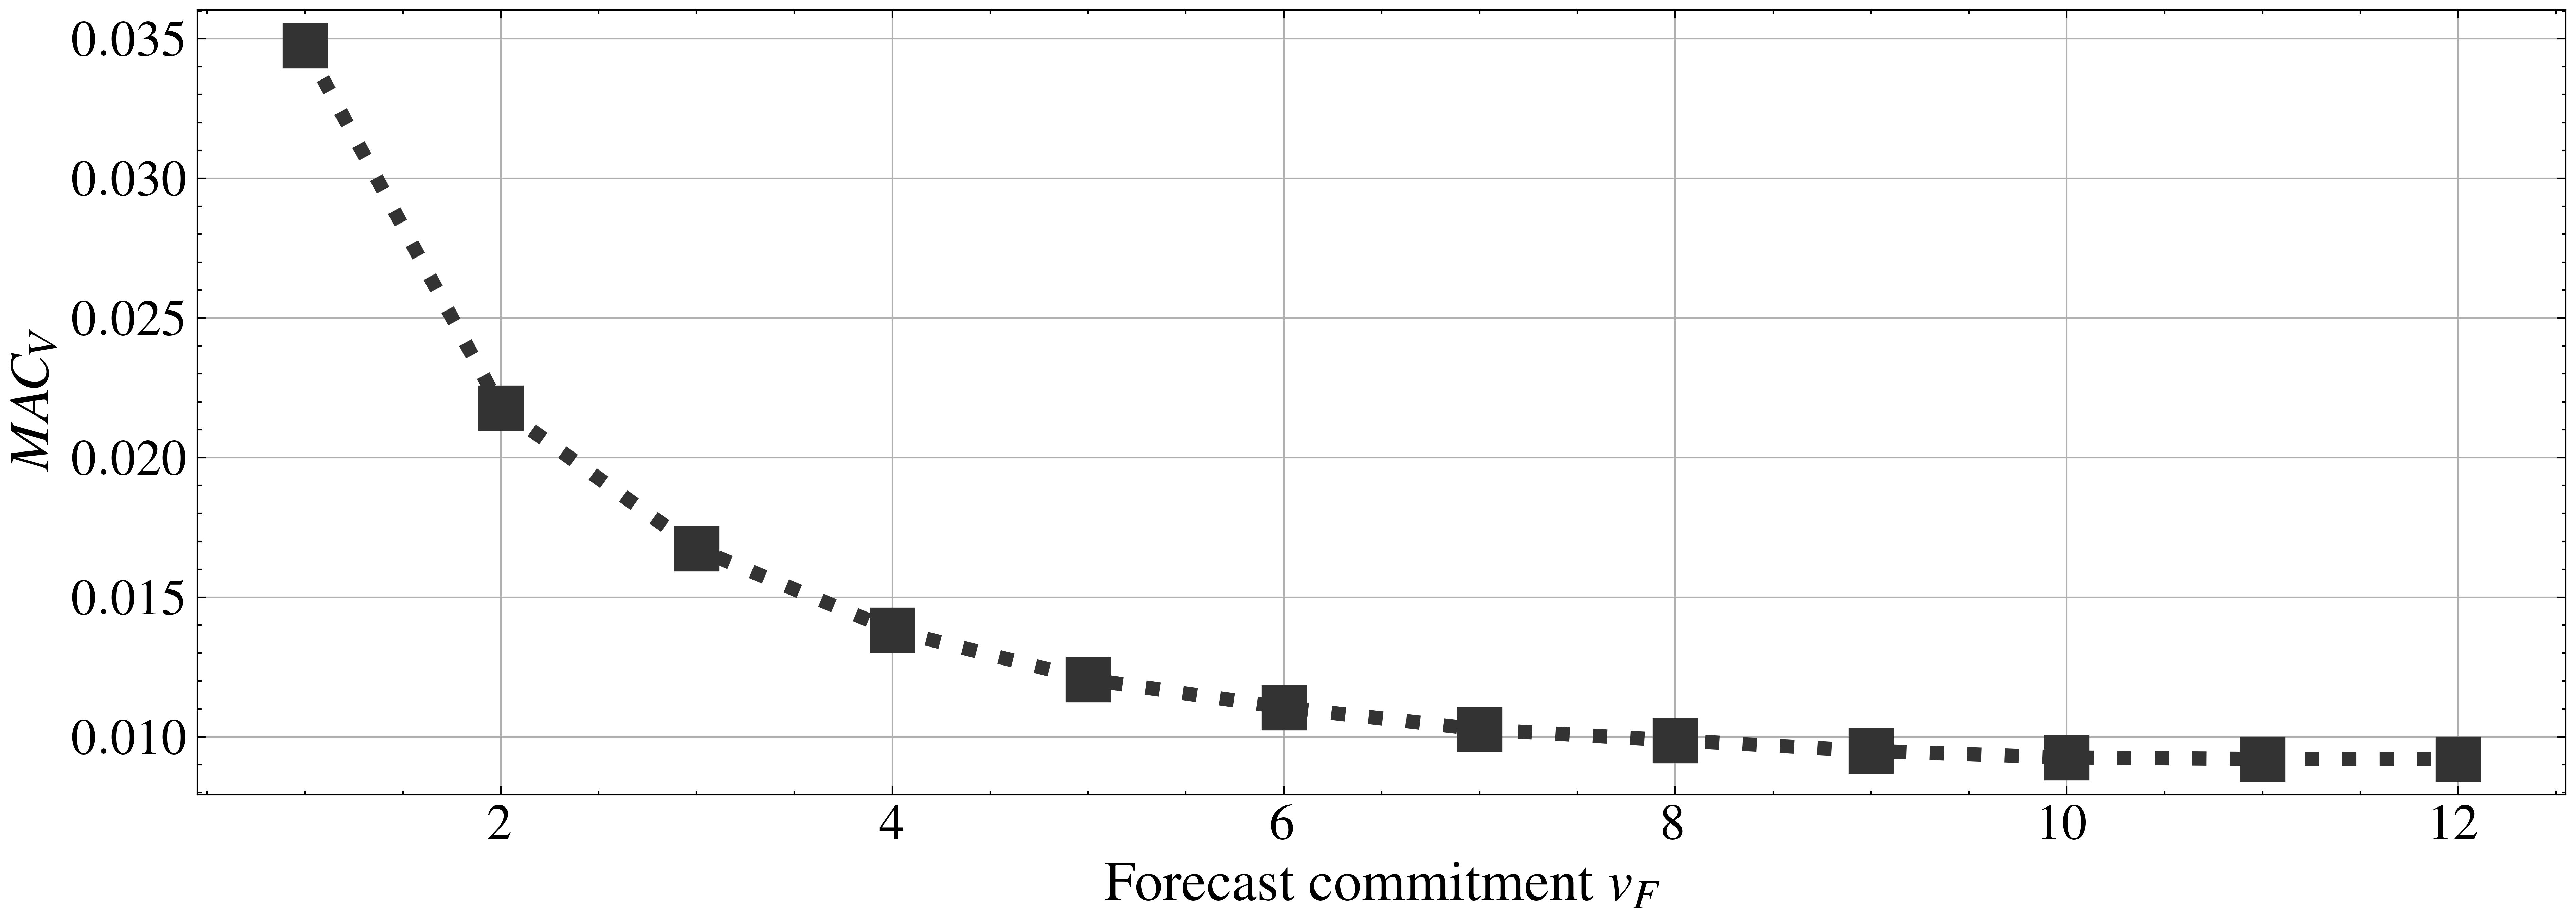

In [8]:
plt.style.use(['science','ieee'])
# plot just the MAC
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(list(MAC_steps_dict.keys())[:12], list(MAC_steps_dict.values())[:12], marker='s', linestyle='dotted', label='In-sample'
        , linewidth=5, markersize=15, color='#333333')
ax.grid(True)

# make x ticks bigger
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

ax.set_xlabel('Forecast commitment $v_{F}$', fontsize=20)
ax.set_ylabel('$MAC_{V}$', fontsize=20)
#ax.set_title(f'Forecast stability (MAC) vs forecast deployment step (In-sample)', fontsize=16)
plt.show()

In [9]:
phase_num = 3
#sMAPC_steps = {}
MAC_steps = {}
#sMAPC_steps_dict = {}
MAC_steps_dict = {}
for step_forecast in range(1, 24):
    #sMAPC_steps[step_forecast] = {}
    MAC_steps[step_forecast] = {}
    tog_forecast = pd.read_csv(f'debug_logs/scen_gurobi_phase_{phase_num}_step_leap_1_forecast_step_{step_forecast}.csv', index_col='time_step')
    for b_num in range(tog_forecast['building'].nunique()):
        tog_forecast_temp = tog_forecast[tog_forecast['building'] == b_num]
        tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
        # impute the row above for missing indexes
        tog_forecast_array = tog_forecast_temp.values
        MAC_v = np.zeros(len(tog_forecast_temp)-1)
        prev_indices, current_indices = generate_lists(1,24)
        for i in range(len(tog_forecast_temp)-1):
            tog_forecast_previous = tog_forecast_array[i, prev_indices]
            tog_forecast_current = tog_forecast_array[i+1, current_indices]
            MAC_v[i] = MAC(tog_forecast_current, tog_forecast_previous)
        print(f'MAC{MAC_v.mean()}')
        MAC_steps[step_forecast][b_num] = MAC_v.mean()
    MAC_steps_dict[step_forecast] = np.mean(list(MAC_steps[step_forecast].values()))

/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.050031155874865944
MAC0.07574556806743002
MAC0.04979611465148138
MAC0.07392653737279292


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.06667064052948239
MAC0.06537698269115559
MAC0.07757633900880162


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.02851328588645953
MAC0.04847795047277202
MAC0.029079824511365763
MAC0.04369215125480307


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.04067738599004393
MAC0.037458186384665734
MAC0.045903056785155334


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.021184461930513435
MAC0.03795686869745454
MAC0.021689207729078317
MAC0.03205893845695785


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.03174285902517097
MAC0.027131148416486305
MAC0.03436488126077472


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.017627211044463097
MAC0.03049913166176055
MAC0.018099765598651722
MAC0.026665339190206677


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.025275612748381582
MAC0.022522903691685452
MAC0.028037774406948514


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.015212065193989295
MAC0.028588078766618112
MAC0.015736519592719964
MAC0.02287168206228411


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.02271251603040297
MAC0.019577654009664547
MAC0.024785678101450763


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.013747010696706898
MAC0.027385329265015947
MAC0.014311165752026138
MAC0.02122042955853252


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.021481781182308143
MAC0.017997087538214898
MAC0.023060634235874605


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.013240727328173297
MAC0.024916264582653492
MAC0.013604745965557902
MAC0.019917271023597825


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.019803837792463173
MAC0.016996465599862474
MAC0.021295729294222562


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.013013140439978725
MAC0.021059155059910493
MAC0.013169843202994497
MAC0.01945982913204164


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.018195449415125537
MAC0.016480234565462167
MAC0.020775362229360394


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.012677462618248892
MAC0.023229420113318373
MAC0.012873894870168195
MAC0.01849885522039022


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.019129870406488062
MAC0.016377660920600723
MAC0.020298451642781472


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.012583548733498503
MAC0.022629350329366155
MAC0.012715387600930009
MAC0.018546228240127978


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.018763579534421527
MAC0.016430671058272426
MAC0.020211235379211673


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.01278770918872825
MAC0.022496753295797287
MAC0.012798300625129468
MAC0.01862469767797721


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.01900126372874053
MAC0.016823003287181088
MAC0.020308297566488834


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.012999520441905445
MAC0.02217313795087321
MAC0.012878081550216615
MAC0.0193485989542478


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.019017720386400712
MAC0.017022619271218946
MAC0.0202190221591058


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.013272532771819338
MAC0.022664306383600286
MAC0.013180475524154689
MAC0.019221719061091103


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.019640737091818714
MAC0.017455874645214618
MAC0.02095078012300085


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.013779068253973065
MAC0.022780153062426787
MAC0.013461534392343788
MAC0.019799146122190678


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.020265280414599622
MAC0.017916782950181762
MAC0.021457782979956947


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.014085658973560952
MAC0.023396618749392792
MAC0.01381199394278498
MAC0.020224039023438372


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.02096037888843495
MAC0.018587224971165463
MAC0.022067898206741095


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.014662418006183484
MAC0.0233016435866365
MAC0.01415302169916761
MAC0.021104376550705385


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.021191575658287897
MAC0.01916722209586066
MAC0.022817268425632142


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.015023005306773704
MAC0.024752947851543
MAC0.014586832070374731
MAC0.021483153399937723


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.022282696187368473
MAC0.019965428364343042
MAC0.023275741052195674


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.015311500843869646
MAC0.02549204175996582
MAC0.01490037254868842
MAC0.022413423802613026


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.02336675784401929
MAC0.02072948568390083
MAC0.02437136373825091


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.01595119779728739
MAC0.026278729661221654
MAC0.015440422677332078
MAC0.022947459763398872


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.023931964346349092
MAC0.02139069286023011
MAC0.024954142984277273


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.01650071891125255
MAC0.026986934615509422
MAC0.015917619722327688
MAC0.023953112807704017


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.024842181331343596
MAC0.022229885529427146
MAC0.02569092270374508


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.017360987210590866
MAC0.02835530899870584
MAC0.016460409104873848
MAC0.02486836270471347


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.025811353911066936
MAC0.02312177128584799
MAC0.02673755244642979


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.017797520954507276
MAC0.029248806802244738
MAC0.01703464355016358
MAC0.0258944826936683


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.026876801016459957
MAC0.024044243819976774
MAC0.02758660020428185


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

MAC0.018361119343565904
MAC0.030419915265716153
MAC0.01756417819955608
MAC0.02693041021975854
MAC0.027892386791770495
MAC0.02507662330399286
MAC0.028808740955346836


/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tog_forecast_temp.drop(columns=['building', 'scenario'], inplace=True)
/var/folders/8b/4kssy4kj57jb6rv1pmm5w8h80000gn/T/ipykernel_81691/346302809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

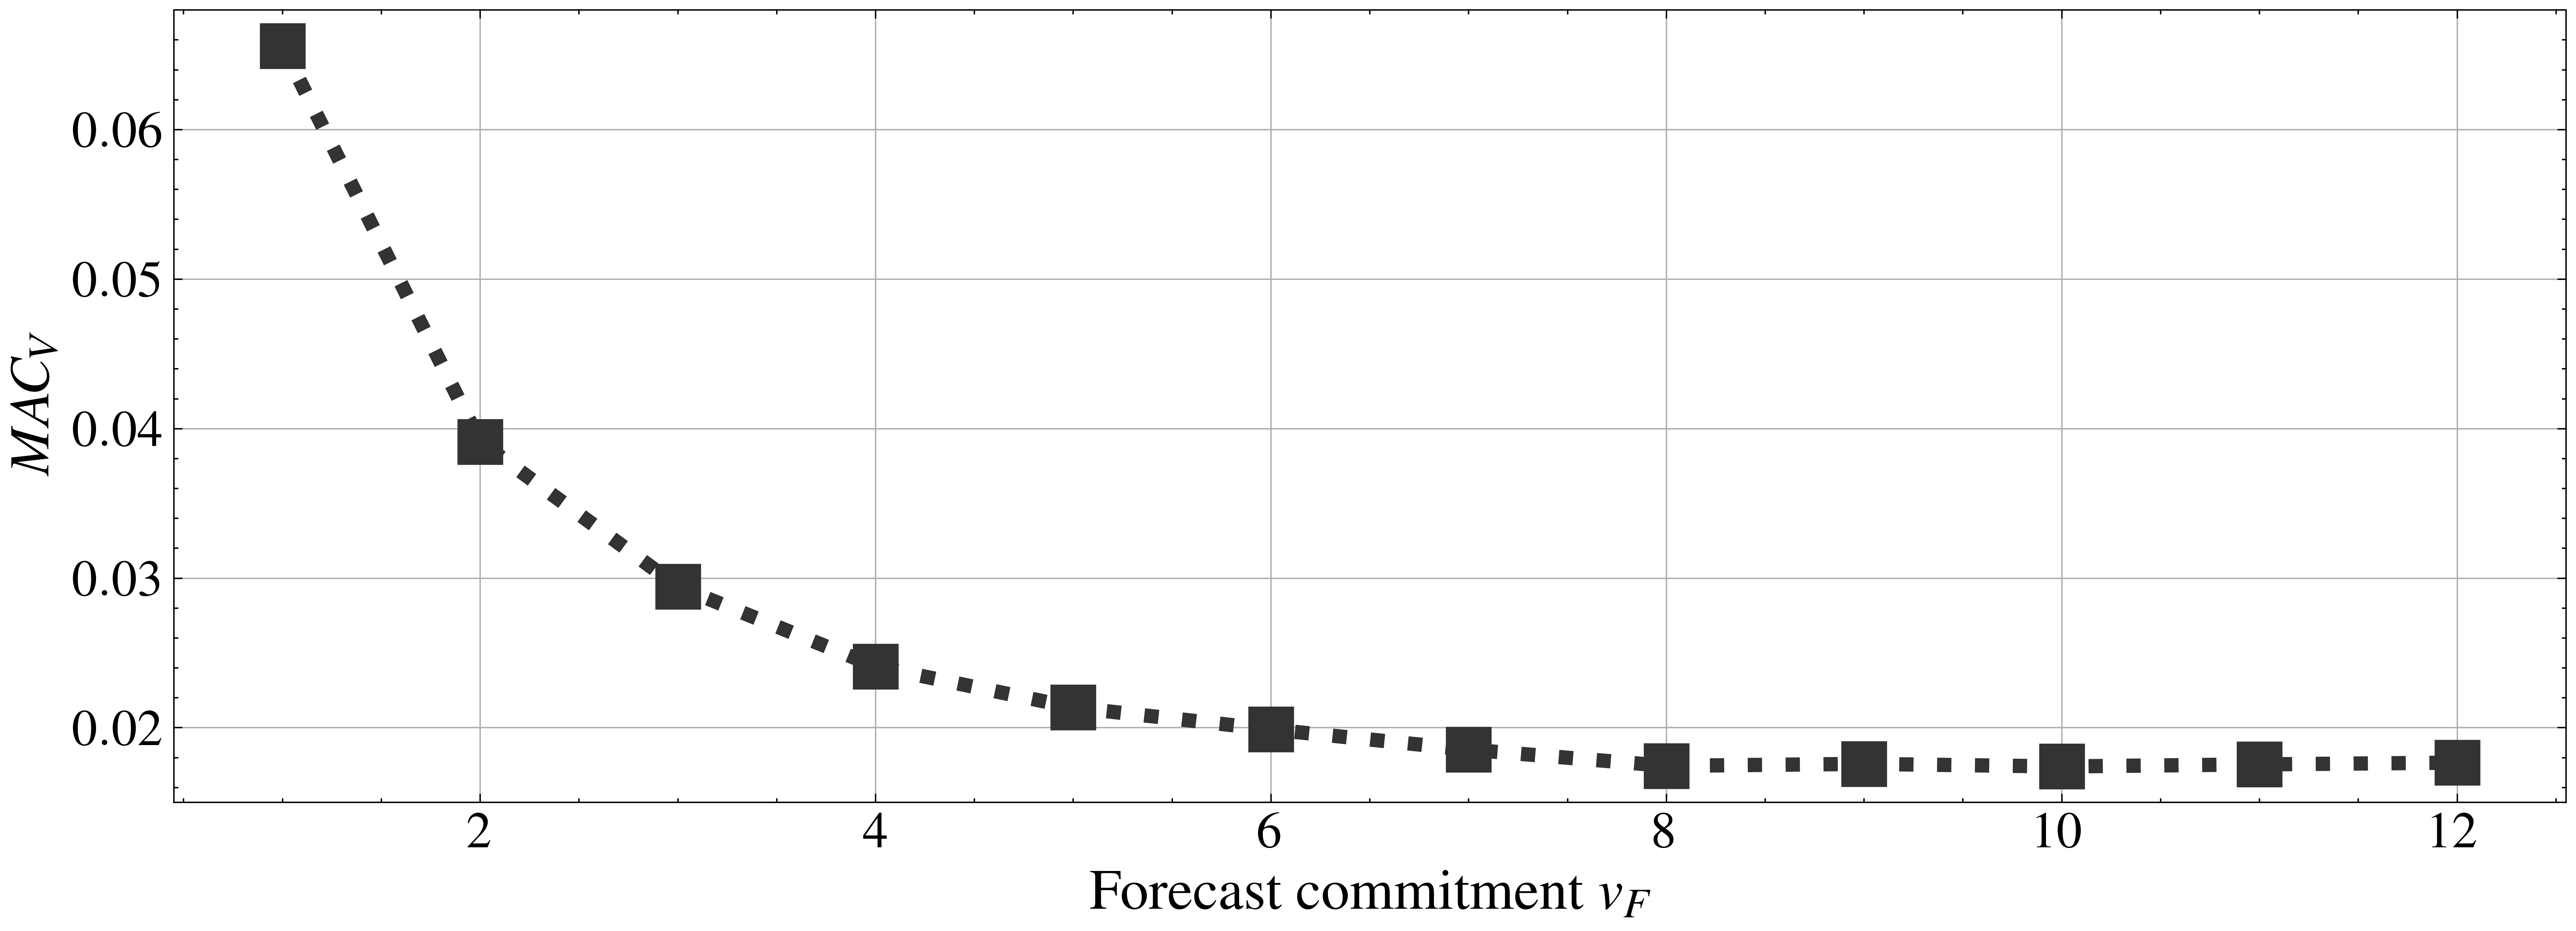

In [10]:
plt.style.use(['science','ieee'])
# plot just the MAC
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(list(MAC_steps_dict.keys())[:12], list(MAC_steps_dict.values())[:12], marker='s', linestyle='dotted', label='In-sample'
        , linewidth=5, markersize=15, color='#333333')

# make x ticks bigger
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

ax.set_xlabel('Forecast commitment $v_{F}$', fontsize=20)
ax.set_ylabel('$MAC_{V}$', fontsize=20)
ax.grid()
#ax.set_title(f'Forecast stability (MAC) vs forecast deployment step (In-sample)', fontsize=16)
plt.show()

In [13]:
# ts_dict to dataframe
df = pd.DataFrame.from_dict(MAC_steps_dict, orient='index', columns=['MAC_V'])
# save to csv
df.to_csv("results/P3_MAC_V.csv")